In [1]:
# Run this once at top of notebook
!pip install -U imbalanced-learn xgboost shap plotly

import warnings
warnings.filterwarnings("ignore")

# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
)
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [3]:
#  Load & initial clean
df = pd.read_csv('/content/creditcard.csv')
print("Initial shape:", df.shape)
print(df.head())

# Drop duplicates
df.drop_duplicates(inplace=True)
print("After dropping duplicates:", df.shape)

# Drop Time if present
if 'Time' in df.columns:
    df.drop(columns=['Time'], inplace=True)
    print("Dropped 'Time' column")


Initial shape: (229789, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

In [4]:
#  Outlier removal and light feature engineering

# Save the DataFrame before outlier removal for comparison
before_df = df.copy()

# Log-transform Amount for more stable distribution (create new column and keep original scaled later)
df['Amount_log'] = np.log1p(df['Amount'].abs())  # use abs() in case of any negative values

# IQR outlier removal on Amount_log (less sensitive than raw amount)
q1 = df['Amount_log'].quantile(0.25)
q3 = df['Amount_log'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

before = df.shape[0]
df = df[(df['Amount_log'] >= lower) & (df['Amount_log'] <= upper)].copy()
after = df.shape[0]
print(f"Removed outliers using IQR on Amount_log: {before - after} rows removed, new shape: {df.shape}")

# Example feature engineering: simple time/velocity proxies if 'Hour' or 'Date' exist
# If dataset has no timestamp fields, skip this safely.
if 'Hour' in df.columns:
    df['is_night'] = df['Hour'].apply(lambda h: 1 if (h < 6 or h >= 22) else 0)
else:
    # crude synthetic feature: fractional part of Amount_log to simulate another signal
    df['amt_frac'] = df['Amount_log'] - np.floor(df['Amount_log'])

Removed outliers using IQR on Amount_log: 218 rows removed, new shape: (228722, 31)


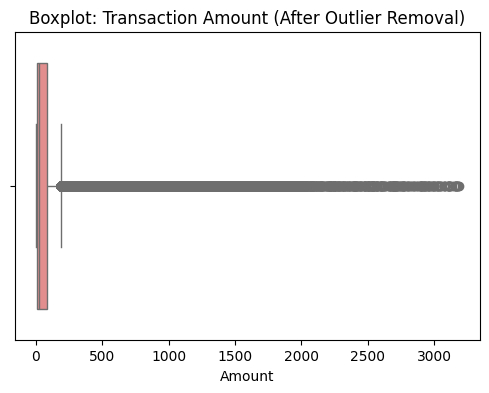

In [5]:
# Boxplot of Original Amount (After Outlier Removal) ---

plt.figure(figsize=(6,4))
sns.boxplot(x=df['Amount'], color='lightcoral')
plt.title("Boxplot: Transaction Amount (After Outlier Removal)")
plt.xlabel("Amount")
plt.show()


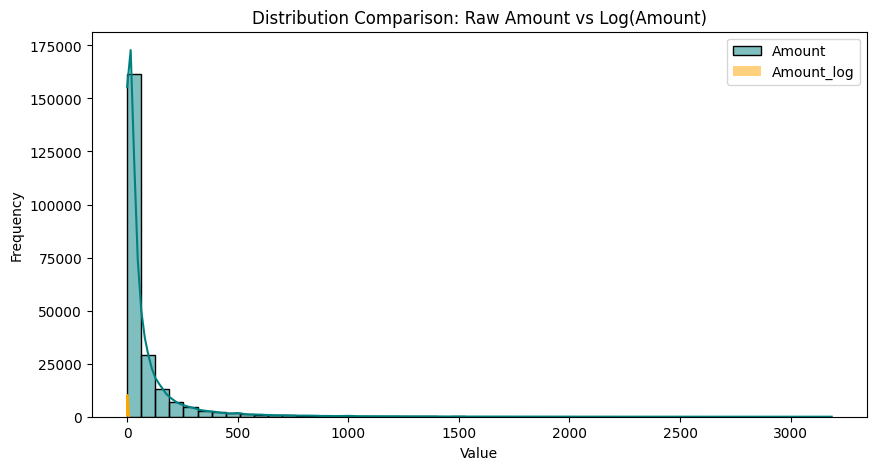

In [6]:
# Distribution Comparison: Amount vs Amount_log ---

plt.figure(figsize=(10,5))
sns.histplot(df['Amount'], bins=50, kde=True, color='teal', label='Amount')
sns.histplot(df['Amount_log'], bins=50, kde=True, color='orange', label='Amount_log')
plt.legend()
plt.title("Distribution Comparison: Raw Amount vs Log(Amount)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


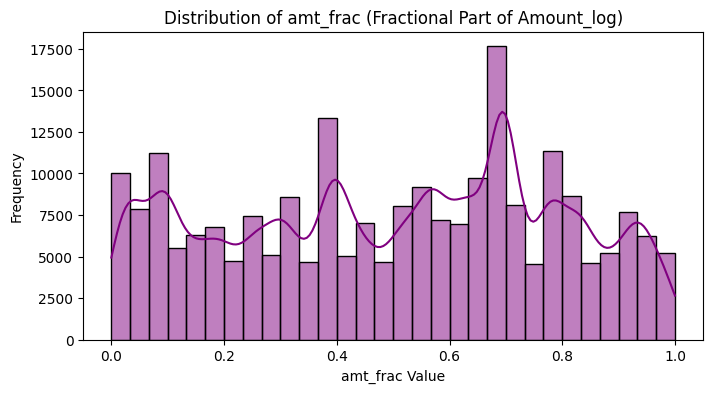

In [7]:
#  Distribution of amt_frac (Fractional Part of Amount_log) ---

if 'amt_frac' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['amt_frac'], bins=30, kde=True, color='purple')
    plt.title("Distribution of amt_frac (Fractional Part of Amount_log)")
    plt.xlabel("amt_frac Value")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Feature 'amt_frac' not found — skipping plot.")


In [8]:
#  3D Visualization of Fraud vs Non-Fraud ---

import plotly.express as px

if 'Class' in df.columns and 'Amount_log' in df.columns:
    # sample to avoid lag if dataset is large
    sample_df = df.sample(min(2000, len(df)), random_state=42)
    fig = px.scatter_3d(
        sample_df,
        x='Amount_log',
        y='amt_frac' if 'amt_frac' in sample_df.columns else 'Amount',
        z='Amount',
        color=sample_df['Class'].astype(str),
        color_discrete_map={'0':'green', '1':'purple'},
        title="3D Scatter: Fraud (purple) vs Non-Fraud (Green) — Amount Features"
    )
    fig.update_traces(marker=dict(size=3))
    fig.show()
else:
    print("Columns required for 3D visualization not found.")


In [9]:
plt.savefig('visual_name.png', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [10]:
# Prepare features and train/test split, scaling
# Keep label column name as 'Class'
assert 'Class' in df.columns, "Dataset must contain 'Class' column"

X = df.drop(columns=['Class'])
y = df['Class']

# Optionally drop any IDs or PAN-like columns if present to avoid leakage
for col in ['CardID', 'card_id', 'PAN', 'pan']:
    if col in X.columns:
        X.drop(columns=[col], inplace=True)

# Standard scale numerical columns (fit on training split only)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)


x_train shape: (182977, 31) x_test shape: (45745, 31)


In [11]:
# Balance with SMOTEENN
print("Before balancing:", Counter(y_train))
sm = SMOTEENN(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print("After SMOTEENN:", Counter(y_train_res))

# Keep the resampled feature set numeric scaling consistent (already scaled)


Before balancing: Counter({0.0: 182656, 1.0: 321})
After SMOTEENN: Counter({1.0: 182656, 0.0: 182307})


In [12]:
# 5 - Hyperparam tuning with RandomizedSearchCV (faster than full grid)
# compute scale_pos_weight from resampled or original training set (use original train ratio)
neg_pos_ratio = (y_train == 0).sum() / max(1, (y_train == 1).sum())
print("Original neg/pos ratio:", neg_pos_ratio)

xgb = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 5],
    'scale_pos_weight': [int(neg_pos_ratio), int(neg_pos_ratio*2), 1]  # try a few scales
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit on the resampled training set
rand_search.fit(x_train_res, y_train_res)

print("Best params:", rand_search.best_params_)
print("Best CV F1:", rand_search.best_score_)
best_xgb = rand_search.best_estimator_


Original neg/pos ratio: 569.0218068535826
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F1: 0.9998138952468475


In [13]:
# 6 - Train final model on resampled training data (best_xgb from tuning)
model_xgb = best_xgb
model_xgb.fit(x_train_res, y_train_res)

# OPTIONAL: save model
import joblib
joblib.dump(model_xgb, "xgb_fraud_model.joblib")
print("Model trained and saved to xgb_fraud_model.joblib")


Model trained and saved to xgb_fraud_model.joblib


In [14]:
# 7 - Evaluate on test set
y_pred = model_xgb.predict(x_test)
y_proba = model_xgb.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec_vals, prec_vals)

print("--- Test set metrics ---")
print(f"Test Accuracy         : {acc:.4f}")
print(f"F1 Score              : {f1:.4f}")
print(f"Precision             : {prec:.4f}")
print(f"Recall                : {rec:.4f}")
print(f"ROC AUC               : {roc_auc:.4f}")
print(f"Precision-Recall AUC  : {pr_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


--- Test set metrics ---
Test Accuracy         : 0.9989
F1 Score              : 0.7263
Precision             : 0.6566
Recall                : 0.8125
ROC AUC               : 0.9867
Precision-Recall AUC  : 0.8463
Confusion matrix:
 [[45631    34]
 [   15    65]]


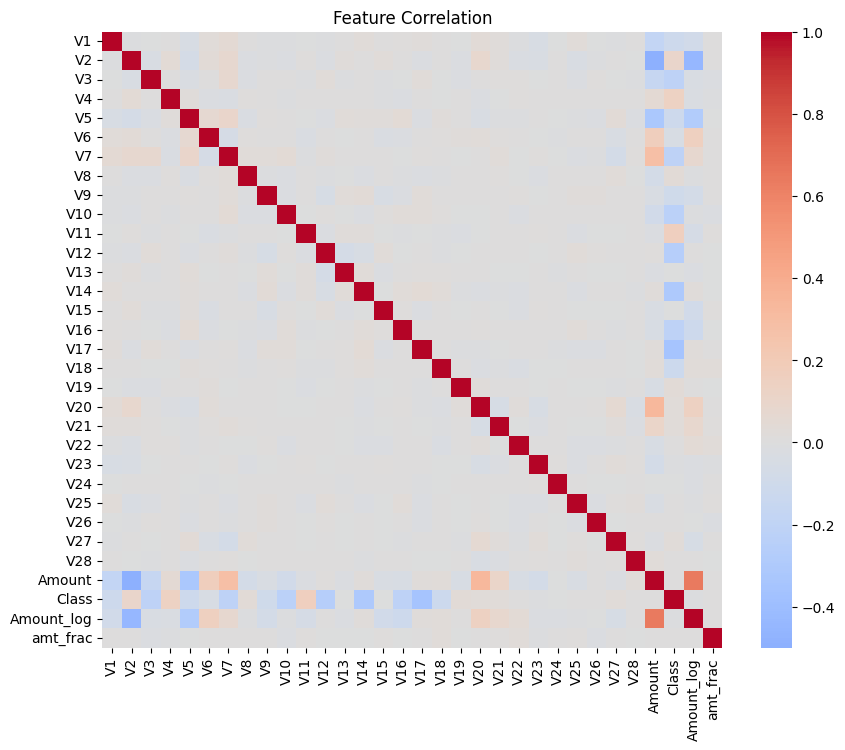

In [15]:
# Correlation heatmap (use a sampled subset if many features)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation")
plt.show()

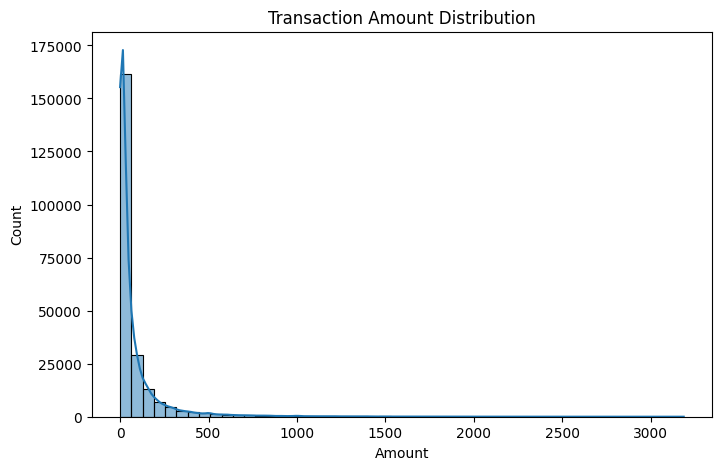

In [16]:
# Amount distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

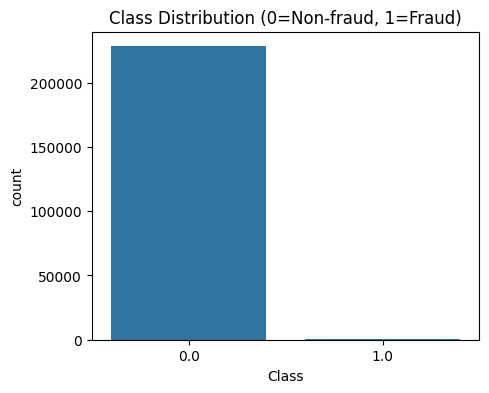

In [17]:
# Fraud class distribution
plt.figure(figsize=(5,4))
sns.countplot(x=df['Class'])
plt.title("Class Distribution (0=Non-fraud, 1=Fraud)")
plt.show()

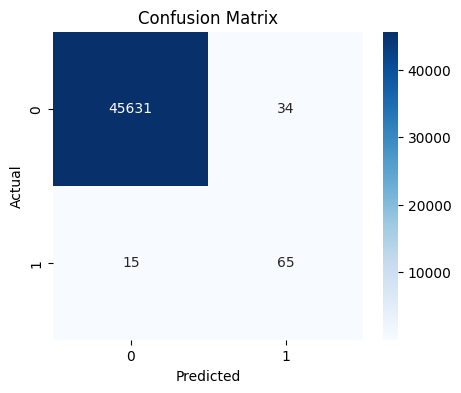

In [18]:
# Confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

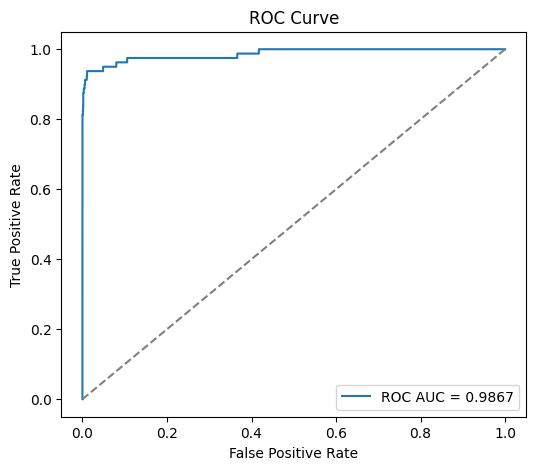

In [19]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

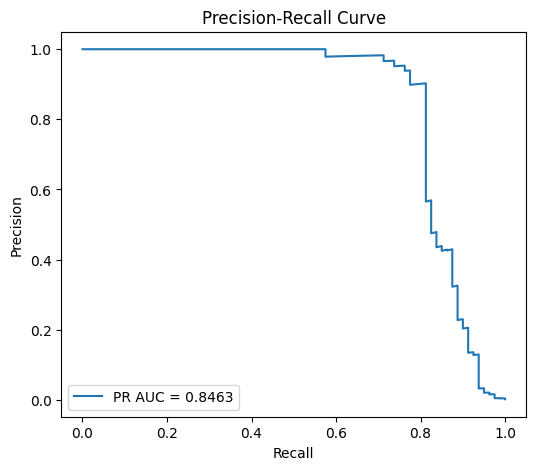

In [20]:
# Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(rec_vals, prec_vals, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [21]:
#  3D visualization using top 3 feature importances (interactive)
importances = pd.Series(model_xgb.feature_importances_, index=x_train.columns)
top3 = list(importances.sort_values(ascending=False).head(3).index)
print("Top 3 features for 3D plot:", top3)

# Sample points for interactivity to keep it light
sample_df = pd.concat([x_test[top3], y_test.reset_index(drop=True)], axis=1).sample(n=min(3000, x_test.shape[0]), random_state=42)
sample_df['Class'] = sample_df['Class'].astype(str)

fig = px.scatter_3d(sample_df, x=top3[0], y=top3[1], z=top3[2],
                    color='Class', title=f'3D scatter on top features: {top3}')
fig.update_traces(marker=dict(size=3))
fig.show()

Top 3 features for 3D plot: ['V14', 'V12', 'V10']


In [23]:
# --- Test a single new transaction manually ---
import numpy as np
import pandas as pd

# Example new transaction (replace values with real data)
new_tx = {
    'V1': 0.45, 'V2': -0.89, 'V3': 1.23, 'V4': 0.33, 'V5': -0.54,
    'Amount': 25.70,
    'Amount_log': np.log1p(25.70)
}



# Create an empty DataFrame with the same columns as x_train, initialized to 0
# This ensures the correct column names and order from the start
new_tx_df = pd.DataFrame(0.0, index=[0], columns=x_train.columns)

# Populate the known values from the example transaction
for col, val in new_tx.items():
    if col in new_tx_df.columns:
        new_tx_df[col].iloc[0] = val

# Scale numeric features
new_tx_df[num_cols] = scaler.transform(new_tx_df[num_cols])

# Ensure column order matches training data exactly for prediction
new_tx_df = new_tx_df[x_train.columns]

# Predict fraud
pred = model_xgb.predict(new_tx_df)[0]
proba = model_xgb.predict_proba(new_tx_df)[0, 1]

# Show result
if pred == 1:
    print(f" Fraud Detected! (Probability: {proba:.4f})")
else:
    print(f" Legitimate Transaction (Probability of Fraud: {proba:.4f})")

 Legitimate Transaction (Probability of Fraud: 0.0316)
